In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !pip install botorch
# !pip install autograd-minimize

In [ ]:
# !git clone https://github.com/rfeinman/pytorch-minimize.git
# %cd pytorch-minimize
# !pip install -e .

fatal: destination path 'pytorch-minimize' already exists and is not an empty directory.
/content/pytorch-minimize
Obtaining file:///content/pytorch-minimize
  Attempting uninstall: torchmin
    Found existing installation: torchmin 0.0.2
    Can't uninstall 'torchmin'. No files were found to uninstall.
  Running setup.py develop for torchmin


In [262]:
import math
import numpy as np

import torch.nn.functional as F
import torch.nn as nn
import torch

import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [263]:
### function to plot trajectory ###

def rotate(x, y, angle):
    return [x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)), 
            x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))]


def generate_road(road_fn, n_samples, domain, eps=0):
    start_x, end_x =  domain
    x = np.linspace(start_x, end_x, n_samples)
    return [(i - eps, road_fn(i)) for i in x]


def plot_trajectory(states, road, verbose=False):

    plt.figure(figsize=(20, 5))
    plt.plot(*zip(*road), color='gold', linestyle='--')

    road = np.array(road)

    colors = cm.rainbow(np.linspace(0, 1, len(states)))
    for i, state in enumerate(states):
        x, y, velocity, heading = state
        heading = heading % 360 
        if verbose:
            print(f"x: {x}, y: {y}, velocity: {velocity}, heading: {heading}")
            print(f"centerline error: {shortestDistanceToPolylineNumpy(np.array([x, y]), road)}")
        plt.plot(x, y, marker=(3, 0, heading - 90), markersize=5, color=colors[i])
    print('\n' * 2)
    plt.show()

In [264]:
road1_formula = lambda x: 2 * x + 0
road1 = generate_road(road1_formula, 500, (-30, 60))

road2_formula = lambda x: 10 * math.log(x + 30) - 30
road2 = generate_road(road2_formula, 500, (-20, 300), eps=.5)

road3_formula = lambda x: math.exp(x / 20) + 4
road3 = generate_road(road3_formula, 500, (-50, 100), eps=.5)

# plt.figure(figsize=(20, 5))
# plt.plot(*zip(*road3), color='gold', linestyle='--')

Input a number of things:

1. k nearest objects to us, with predictions of locations in near future
2. Road-map, center-lines, etc. (polylines as features)
3. Desired waypoint destination (x, y features) given by another larger coarse network

In [266]:
from torch.utils.data import Dataset

def buildDataset(n, seq_len, desired_v, init_velocity=None, init_heading=None):
    dataset, initialStates = [], []

    for _ in range(n):
        # x = np.random.normal(0, 3)
        # y = np.random.normal(0, 3)
        v = np.random.normal(0, 2)
        h = np.random.normal(0, 10)
        x = 0
        y = 0

        if init_velocity is not None:
            v = init_velocity
        if init_heading is not None:
            h = init_heading

        dataset.append([[x, y, v, h, desired_v]])
        initialStates.append([[x], [y], [v], [h], [desired_v]])
    
    dataset = np.array(dataset)
    initialStates = np.array(initialStates)
    return dataset, initialStates


class ControlsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        return self.data[0][idx], self.data[1][idx]

In [267]:
# state: [[x1, y1, v1, h1], [x2, y2, v2, h2], ...]
# controls: [vx, vy, a, w]
def stateUpdateEqn(state, controls, timeStep):
    controls[0, 0] = state[2, 0] * torch.cos(torch.deg2rad(state[3, 0]))
    controls[1, 0] = state[2, 0] * torch.sin(torch.deg2rad(state[3, 0]))
    return state + timeStep * controls


def shortestDistanceToPolyline(pt, centerLinePts, discretization=3):

    distance = torch.tensor(float('inf'))
    tangentLine = None 
    for i in range(discretization, len(centerLinePts), discretization):
        ptA, ptB = centerLinePts[i - discretization], centerLinePts[i]

        centerLine = ptB - ptA
        midPt = (ptA + ptB) / 2
        projection = midPt
        
        # projection = (centerLine[0] * ptShift[0] + centerLine[1] * ptShift[1]) / torch.norm(centerLine, p=2)
        # projection = projection * centerLine + ptA

        rejection_dist = torch.sqrt(torch.square(pt[0] - projection[0]) + torch.square(pt[1] - projection[1]))
        if rejection_dist < distance:
            tangentLine = centerLine
            distance = rejection_dist

    return distance, torch.atan2(tangentLine[1], tangentLine[0])


def computeHeadingError(realHeading, desiredHeading):
    delta = desiredHeading - torch.deg2rad(realHeading)
    return torch.rad2deg(torch.atan2(torch.sin(delta), torch.cos(delta)))

class CompletePathLoss(nn.Module):

    def __init__(self):
        pass 

    def forward(self):
        pass


class AvoidanceLoss(nn.Module):

    def __init__(self):
        pass

    def forward(self, objects):
        pass


constraints = np.array([[0, 0, 0, 0],
                        [0, 0, 0, 0],
                        [0, 0, 3, 0],
                        [0, 0, 0, 40]])


class PlannerLoss(nn.Module):

    constraints = torch.tensor(constraints, dtype=torch.double)
    
    def __init__(self,
                 costWeights,
                 desiredStates,
                 timeStep=1,
                 lineDiscretization=3,
                 gpu=False):
        super(PlannerLoss, self).__init__()

        self.gpu = gpu
        self.timeStep = timeStep
        self.centerLineWeight, self.velocityWeight, self.headingWeight = costWeights
        self.lineDiscretization = lineDiscretization
        self.desiredVelocity = desiredStates

        if gpu:
            self.constraints = self.constraints.cuda()
        

    def forward(self, initialState, controls, centerLines, verbose=1):
        totalBatchCost = 0
        batchDim = initialState.size(0)
        
        for i in range(batchDim):
            cost = 0
            state = initialState[i,:-1,...]
            centerLine = centerLines[i,...]
            for j in range(controls.size(1)):
                paddedControls = torch.cat((torch.zeros(2, 1), controls[i,j,...]))
                state = stateUpdateEqn(state, torch.matmul(self.constraints, paddedControls), self.timeStep)

                stateSqueeze = torch.squeeze(state)
                cartesian, polar = stateSqueeze[:2], stateSqueeze[2:]
                x, y = cartesian; velocity, heading = polar

                lateralError, roadHeading = shortestDistanceToPolyline(cartesian, centerLine, self.lineDiscretization)
                headingError = computeHeadingError(heading, roadHeading)
                velocityError = self.desiredVelocity - velocity
                
                if verbose:
                    print(f"state {j+1}:")
                    print(f"x: {x}, y: {y}, velocity: {velocity}, heading: {heading}")
                    print("distance error:", lateralError)
                    print("velocity error:", velocityError)
                    print("heading error:", headingError)

                centerLineWeight = self.centerLineWeight * (j + 1) 
                headingWeight = self.headingWeight * (j + 1) 
                velocityWeight = self.velocityWeight * (j + 1) 

                cost += centerLineWeight * torch.abs(lateralError)
                cost += velocityWeight * torch.abs(velocityError)
                cost += headingWeight * torch.abs(headingError)

            totalBatchCost += cost / controls.size(1)

        return totalBatchCost / batchDim


def shortestDistanceToPolylineNumpy(pt, centerLinePts):

    distance = float('inf')

    for i in range(1, len(centerLinePts)):
        ptA, ptB = centerLinePts[i - 1], centerLinePts[i]
        # see here: http://www.math.lsa.umich.edu/~glarose/classes/calcIII/web/13_5/
        # shift points to origin (offset by ptA)
        ptShift = pt - ptA
        centerLine = ptB - ptA

        projection = (centerLine[0] * ptShift[0] + centerLine[1] * ptShift[1]) / np.linalg.norm(centerLine, ord=2)
        projection = projection * centerLine + ptA

        rejection_dist = np.sqrt(np.square(pt[0] - projection[0]) + np.square(pt[1] - projection[1]))
        distance = np.minimum(rejection_dist, distance)

    return distance


def stateUpdateEqnNumpy(state, controls, timeStep):
    controls[0, 0] = state[2, 0] * np.cos(np.deg2rad(state[3, 0]))
    controls[1, 0] = state[2, 0] * np.sin(np.deg2rad(state[3, 0]))
    return state + timeStep * controls


def getUpdatedStates(initialState, controls, timeStep=1):
    state = initialState[0][:-1]
    states = [state]
    for control in controls[0]:
        paddedControls = np.concatenate((np.zeros((2, 1)), control))
        state = stateUpdateEqnNumpy(state, constraints @ paddedControls, timeStep)
        states.append(state)
    return states

In [268]:
# MODEL

# Recurrent neural network
class PathPlanner(nn.Module):
    def __init__(self, 
                 output_size,
                 hidden_size, 
                 n_features,
                 y_features, 
                 num_layers, 
                 road_samples,
                 gpu=0):
        super(PathPlanner, self).__init__()

        self.gpu = gpu

        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        road_samples, road_embedding = road_samples

        input_size = n_features + road_samples // road_embedding

        self.road_embed = RoadMapper(road_samples, road_embedding)
        self.features_embed = nn.Linear(input_size, hidden_size)
    
        self.rnn = nn.RNN(hidden_size, 
                          hidden_size,
                          num_layers, 
                          batch_first=True,
                          )
                            
        self.fc1 = nn.Linear(hidden_size, y_features)
        

    def forward(self, x, roadmap):
        batch_size = x.size(0)

        road = self.road_embed(roadmap)
        road = torch.tile(road, (1, 1, 1))
        
        x = torch.cat((x, road), axis=-1)

        x = self.features_embed(x)
        x = nn.Tanh()(x)

        # Set initial hidden and cell states 
        h_n = torch.zeros(self.num_layers, batch_size, self.hidden_size, dtype=torch.double)

        y = torch.zeros(batch_size, self.output_size, self.hidden_size, dtype=torch.double)
        for i in range(self.output_size):
            x, h_n = self.rnn(x, h_n)
            x = nn.Tanh()(x)
            y[:,i,:] = x
        
        y = self.fc1(y)
        y = nn.Tanh()(y)
        y = torch.unsqueeze(y, axis=-1)

        return y


class RoadMapper(nn.Module):
    def __init__(self, samples, embedding):
        super(RoadMapper, self).__init__()
        self.fc1 = nn.Linear(2, 1)
        self.fc2 = nn.Linear(samples, samples // embedding)
    
    def forward(self, x):
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = torch.swapaxes(x, -1, -2)

        x = self.fc2(x)
        x = nn.Tanh()(x)

        return x


# consider the objects around vehicle
class EnvironmentEmbedder(nn.Module):
    def __init__(self, samples,  states, controls):
        super(EnvironmentEmbedder, self).__init__()
        self.controller = nn.Sequential(
            nn.Linear(),
            nn.BatchNorm1d(),
        )
        
    
    def forward(self, x):
        z = self.sampler(x)
        return z

Number of trainable params in model: 75920

inital heading 270.0 

state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.115401111121742, heading: 269.3425918416618
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.1154, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.1641, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: 0.02427144628215123, y: 4.340881550754187, velocity: -1.7814035919027222, heading: 268.3662313900061
distance error: tensor(0.6399, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.7814, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.4276, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: 0.07506064769367103, y: 6.121560975654665, velocity: -1.3272148516954887, heading: 273.01524145368154
distance error: tensor(1.8285, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.3272, dtype=tor

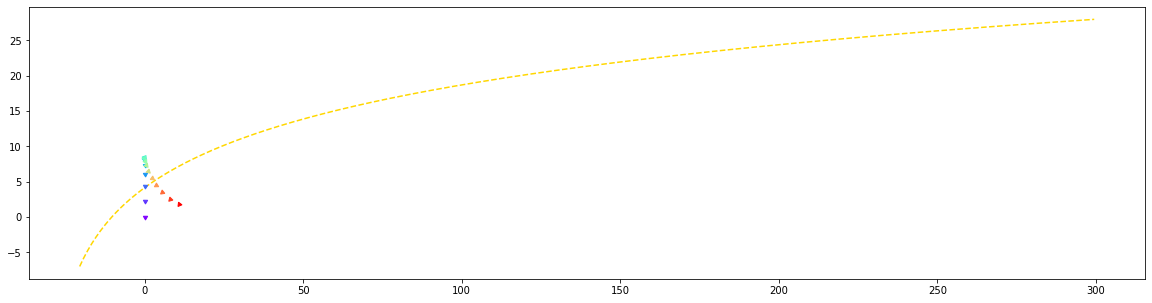


loss = 4594.3295447993505


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.0813881279353548, heading: 270.70884635906845
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.0814, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(107.7979, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.025749658566537346, y: 4.306848528023027, velocity: -1.6481792412281142, heading: 272.66033832466627
distance error: tensor(0.6835, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.6482, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(105.8464, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.10224986692322183, y: 5.95325143416012, velocity: -1.0635923363112942, heading: 281.2027215440878
distance error: tensor(1.7402, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.0636, dtype=torch.float64, grad_fn=<RsubBackward1

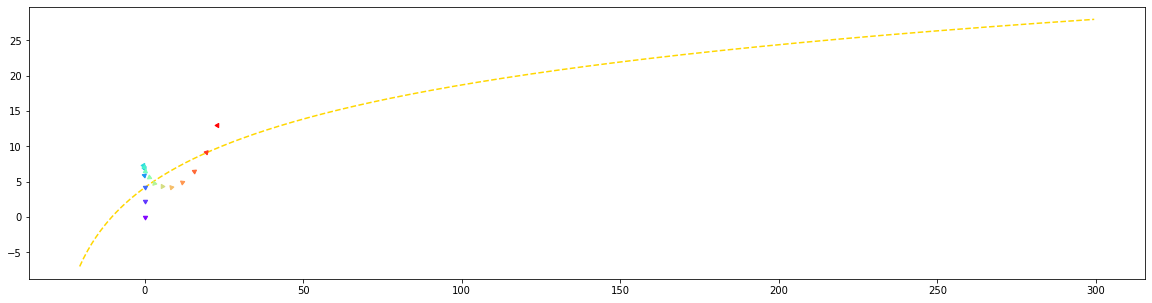


loss = 3288.2306692516063


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.0154009716919097, heading: 270.77108715332855
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.0154, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(107.7357, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.027122466971168355, y: 4.240838147407768, velocity: -1.4288472379738557, heading: 272.927233282796
distance error: tensor(0.6522, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.4288, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(105.5795, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.10009031775088129, y: 5.667821021242666, velocity: -0.6312837367789033, heading: 281.21429625679025
distance error: tensor(1.4880, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.6313, dtype=torch.float64, grad_fn=<RsubBackward1

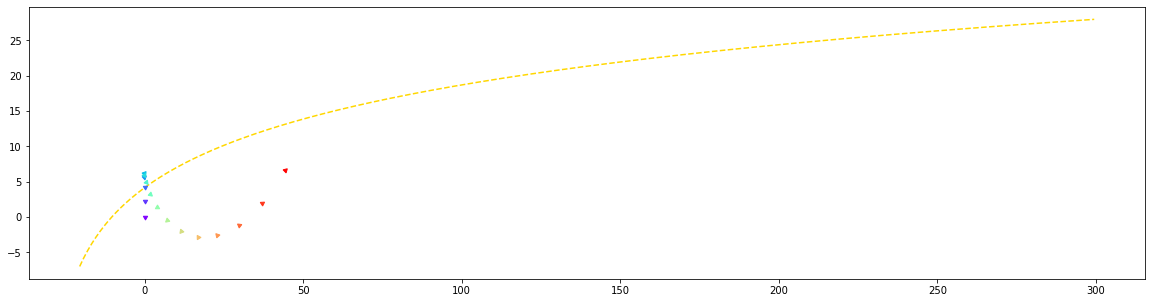


loss = 2927.3425288920143


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -1.985678272816037, heading: 271.1185439851696
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.9857, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(107.3882, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.03876249573904748, y: 4.210919580422355, velocity: -1.3043477663716114, heading: 274.2854682933058
distance error: tensor(0.6296, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.3043, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(104.2213, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.1362309419899359, y: 5.511620544373735, velocity: -0.40776425511967784, heading: 283.22286894271446
distance error: tensor(1.3769, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.4078, dtype=torch.float64, grad_fn=<RsubBackward1>)

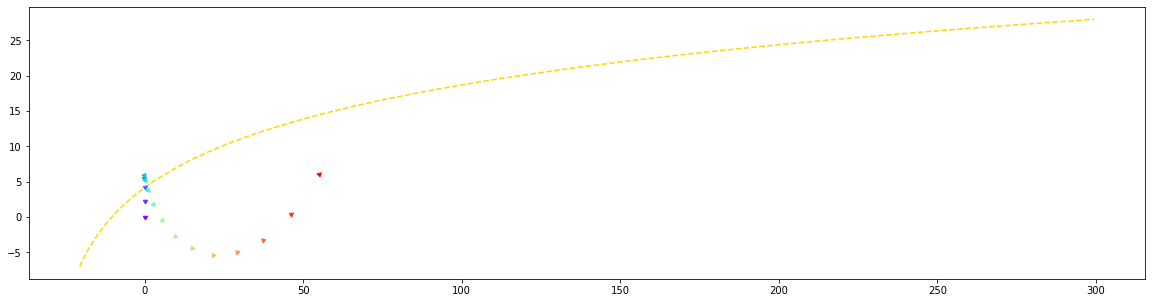


loss = 2830.9839176408905


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.0071978471322858, heading: 271.72660373444853
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.0072, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(106.7801, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.0604775922459481, y: 4.231906220144838, velocity: -1.3307196614487513, heading: 276.0528244795141
distance error: tensor(0.6182, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.3307, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(102.4539, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.2007957650287867, y: 5.555207254586043, velocity: -0.47091154950201264, heading: 285.38304077954524
distance error: tensor(1.4501, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.4709, dtype=torch.float64, grad_fn=<RsubBackward1>

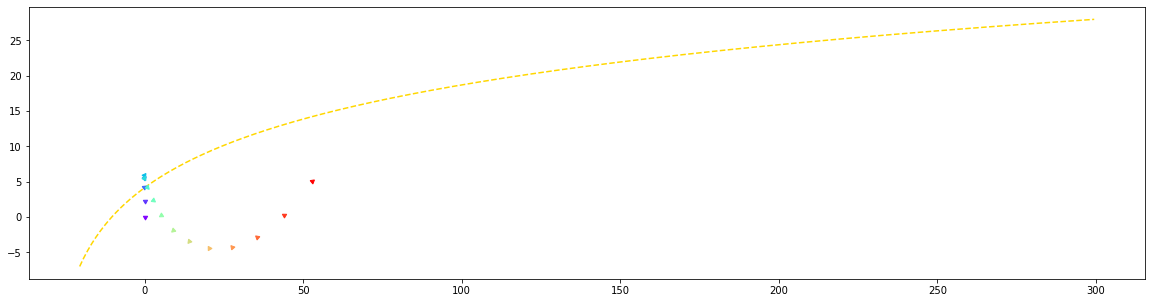


loss = 2739.468901614162


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.0313259282988048, heading: 272.4170876928905
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.0313, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(106.0897, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.08566838152979718, y: 4.255138336836341, velocity: -1.3656473337308896, heading: 277.7527233522089
distance error: tensor(0.6061, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.3656, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(100.7540, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.2698915130108363, y: 5.608302952821258, velocity: -0.5123768322744957, heading: 287.6300488050155
distance error: tensor(1.5341, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.5124, dtype=torch.float64, grad_fn=<RsubBackward1>)
h

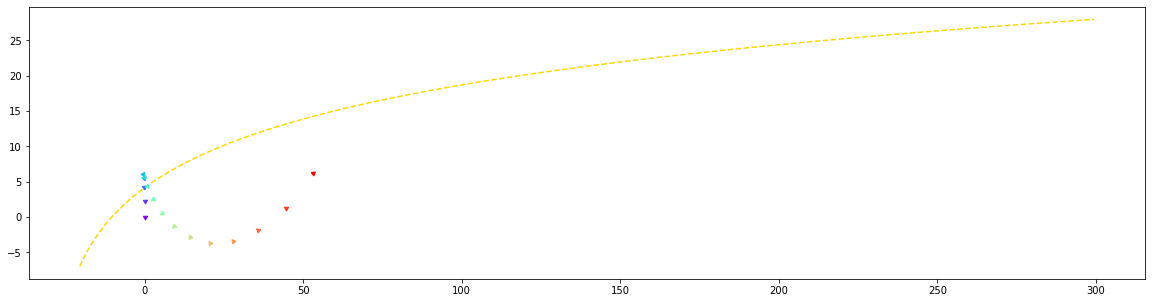


loss = 2665.9287144131126


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.0580316640738467, heading: 273.028374941324
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.0580, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(105.4784, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.10872685675376072, y: 4.280777295440741, velocity: -1.412828275385043, heading: 279.4188859760632
distance error: tensor(0.5988, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.4128, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(99.0879, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.33993782836408276, y: 5.674558204455671, velocity: -0.5732700514064135, heading: 290.00773849207997
distance error: tensor(1.6293, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.5733, dtype=torch.float64, grad_fn=<RsubBackward1>)
h

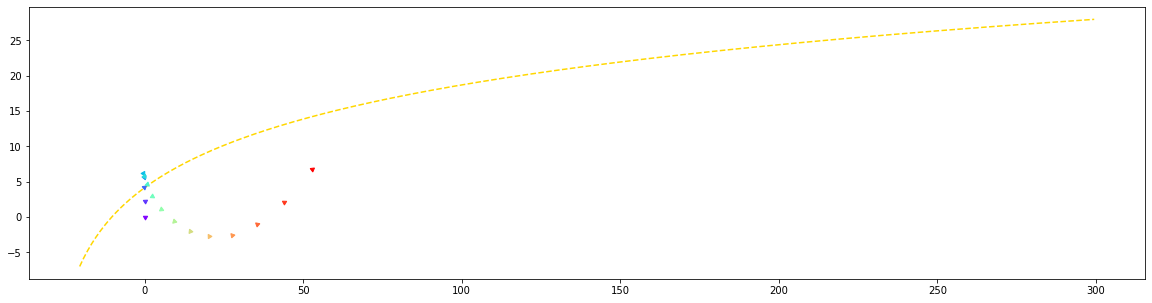


loss = 2583.849801579142


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.0808208707301667, heading: 273.6040333499945
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.0808, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(104.9027, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.13080201403110348, y: 4.302325329048408, velocity: -1.4536449747151075, heading: 281.14029755865977
distance error: tensor(0.5919, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.4536, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(97.3664, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.41166379276052323, y: 5.728579294428849, velocity: -0.6216544120806551, heading: 292.56615139868387
distance error: tensor(1.7162, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.6217, dtype=torch.float64, grad_fn=<RsubBackward1>)

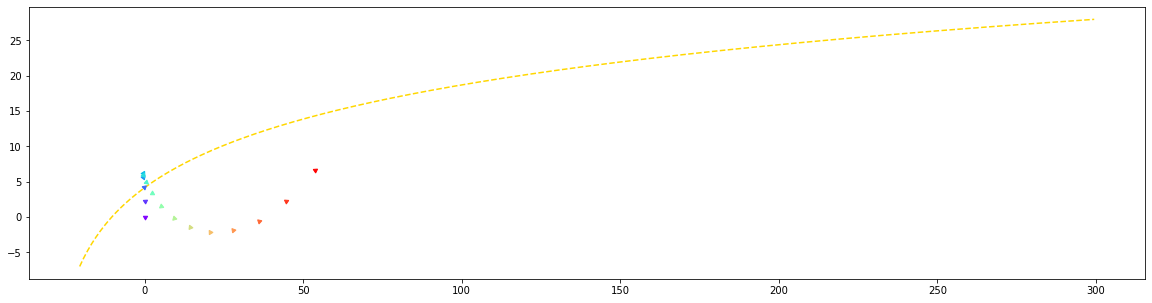


loss = 2484.3401065771527


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.1098773831258617, heading: 274.51667864429953
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.1099, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(103.9901, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.16615135076436974, y: 4.328944743884706, velocity: -1.5249310595888028, heading: 283.3650753834867
distance error: tensor(0.5791, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.5249, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(95.1417, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.5186466455558906, y: 5.812576033541427, velocity: -0.7163173629792318, heading: 295.9884630565546
distance error: tensor(1.8459, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.7163, dtype=torch.float64, grad_fn=<RsubBackward1>)


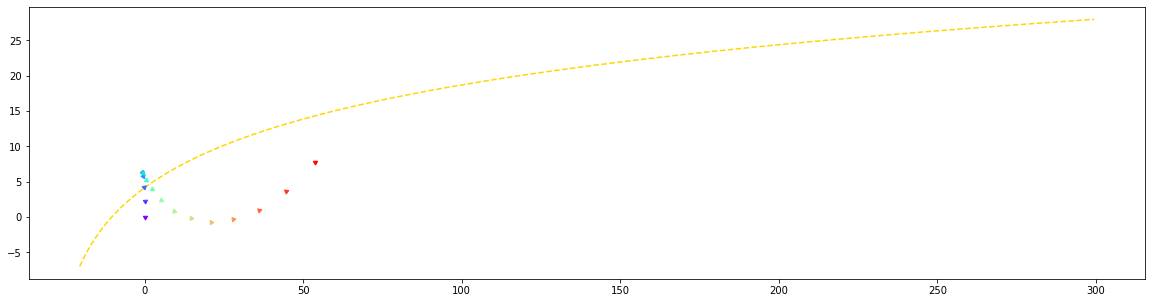


loss = 2331.8960721445237


state 1:
x: 4.0883970362839153e-16, y: 2.2256196856815733, velocity: -2.1589316010230832, heading: 275.78997187078437
distance error: tensor(1.8509, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(12.1589, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(102.7168, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -0.21779769996007087, y: 4.373537239915953, velocity: -1.6385784016385383, heading: 286.1394525536349
distance error: tensor(0.5703, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(11.6386, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(92.3673, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.6732834284586602, y: 5.947535946856469, velocity: -0.8730317122473645, heading: 300.3863760629588
distance error: tensor(1.9787, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.8730, dtype=torch.float64, grad_fn=<RsubBackward1>)


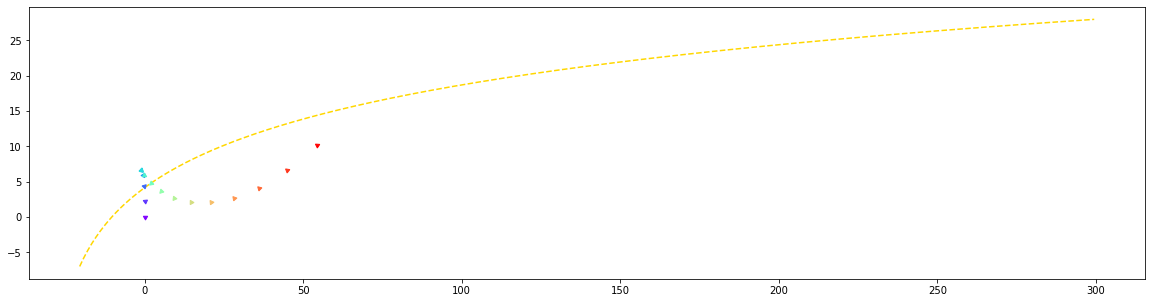


loss = 2051.271528535248




In [269]:
from torch.utils.data import DataLoader

n_steps = 15

n_features = 5
n_layers = 5

hidden_dim = 30
output_features = 2

road_downsample = 4

road = road2
center_line = torch.unsqueeze(torch.tensor(road), dim=0)

timestep = 1.0
line_discrete = 2

desired_velocity = 10 # m/s
init_heading = 270
init_velocity = 0

cost_fn_weights = [4, 20, 7] # centerLineWeight, velocityWeight, headingWeight

# model = PathPlanner(n_steps, n_features, hidden_dim, (road_downsample, output_size), n_layers, len(road2))

model = PathPlanner(n_steps, hidden_dim, n_features, output_features, n_layers, (len(road2), road_downsample))
model = model.double()

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable params in model: {pytorch_total_params}\n')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = PlannerLoss(cost_fn_weights, desired_velocity, timestep, line_discrete)
x, initial_states = buildDataset(1, n_steps, desired_velocity, init_heading=init_heading)
x = torch.tensor(x, dtype=torch.double)

print("inital heading", np.squeeze(initial_states)[-2] % 360, '\n')

initial_states = torch.tensor(initial_states, dtype=torch.double)

# for testing only
# test_trajectory = getUpdatedStates(initial_states.detach().numpy(), generateRandomControls(6))
# plot_trajectory(x.detach().numpy()[0][...,:-1], road, verbose=1)
# print('\n\n')

epochs = 201
display = 20

best_loss, best_soln = float('inf'), None

for epoch in range(epochs + 1):
    model.train()

    controls_output = model(x, center_line)
    loss = loss_fn(initial_states, controls_output, center_line, verbose=(epoch % display == 0 and epoch != 0))

    if loss < best_loss:
        best_loss = loss
        best_soln = getUpdatedStates(initial_states.detach().numpy(), controls_output.detach().numpy(), timestep)

    if epoch != 0 and epoch % display == 0:
        print_states = getUpdatedStates(initial_states.detach().numpy(), controls_output.detach().numpy(), timestep)
        plot_trajectory(print_states, road, verbose=0)
        print(f'\nloss = {loss}\n\n')

    model.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# from torch.utils.data import DataLoader

# batch_size = 10 
# n_workers = 1

# n_steps = 8

# train_dataset = ControlsDataset(buildDataset(100000, n_steps))
# val_dataset = ControlsDataset(buildDataset(20000, n_steps))
# # train_dataset = ControlsDataset(buildDataset(5, n_steps))
# # val_dataset = ControlsDataset(buildDataset(2, n_steps))
# validation_set = DataLoader(val_dataset,
#                             batch_size=batch_size,
#                             shuffle=True,
#                             num_workers=n_workers,
#                            )
# training_set = DataLoader(train_dataset,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           num_workers=n_workers,
#                          )
# dataset = { 'validation': validation_set, 'train': training_set }

In [ ]:
# n_features = 4
# n_layers = 7

# best_path = '/content/drive/My Drive/Research/cc_best.pth'
# chkpt_path = '/content/drive/My Drive/Research/cc_chkpt.pth'

# hidden_dim = n_features
# output_size = n_features

# learning_rate = 1e-2

# log_batch = 1000

# zero_heading = 270 # degrees(°)
# runway_heading = 54.331
# desired_states = (50, runway_heading + zero_heading) # m/s, degrees(°)
# center_line = torch.tensor([2421, -1737], dtype=torch.double)
# cost_fn_weights = [13, 2, 6] # centerLineWeight, velocityWeight, headingWeight

# gpu_exists = torch.cuda.device_count() > 0
# print(f'GPU: {int(gpu_exists)}')

# model = RNN(n_features, hidden_dim, output_size, n_layers, gpu=gpu_exists)
# model = model.double()
# model.load_state_dict(torch.load(chkpt_path))

# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'Number of trainable params in model: {pytorch_total_params}')

# if gpu_exists:
#     model = model.cuda()
#     center_line = center_line.cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = PathLoss(desired_states, center_line, cost_fn_weights, gpu=gpu_exists)

# best_loss = 1e20
# epochs = 100
# for epoch in range(epochs):
#     for phase in ['train', 'validation']:
#         cumu_loss = 0
#         total_loss = 0
#         break_line = '-' * 20
#         print(f'{break_line}\n{phase} at epoch no. {epoch + 1}\n{break_line}')
#         for i, sample in enumerate(dataset[phase]):
#             x, initial_states = sample

#             if gpu_exists:
#                 x = x.cuda()
#                 initial_states = initial_states.cuda()

#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             controls_output = model(x)
#             loss = loss_fn(initial_states, controls_output, verbose=0)

#             cumu_loss += loss
#             total_loss += loss
#             if phase == 'train':
#                 model.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             if i != 0 and i % log_batch == 0:                
#                 print(f'batch {i}: loss = {cumu_loss / log_batch}')
#                 if gpu_exists:
#                     save_model = model.module if torch.cuda.device_count() > 1 else model
#                 else:
#                     save_model = model
#                 torch.save(save_model.state_dict(), chkpt_path)
#                 cumu_loss = 0

#         if phase == 'validation':
#             if total_loss / len(dataset['validation']) < best_loss:
#                 best_loss = total_loss / len(dataset['validation'])
#                 print(f'Loss improved! ({best_loss}) Saving model...')
#                 if gpu_exists:
#                     save_model = model.module if torch.cuda.device_count() > 1 else model
#                 else:
#                     save_model = model
#                 torch.save(save_model.state_dict(), best_path)

#         if gpu_exists:
#             save_model = model.module if torch.cuda.device_count() > 1 else model
#         else:
#             save_model = model
#         torch.save(save_model.state_dict(), chkpt_path)